In [1]:
%cd /workarea/otdMDP/users/amoskovtsev/Pycharm_proj/MB_OPC/custom_unet

/workarea/otdMDP/users/amoskovtsev/Pycharm_proj/MB_OPC/custom_unet


In [2]:
import sys
import os
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.dataset import OPCDataset, TestDataset, BinarizeTransform, apply_transform
from src.utils import MobileNetPerceptualLoss, IouLoss
# import matplotlib
# import os

In [3]:
class EvalDataset(Dataset):
    def __init__(self, target_dir, mask_dir, transform=None):
        self.target_dir = target_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(target_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        target_path = os.path.join(self.target_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        target = Image.open(target_path)
        mask = Image.open(mask_path)
        
        if self.transform:
            target = self.transform(target)
            mask = self.transform(mask)
        return target, mask


## Perceptual loss для `VGG` (pretrained on ImageNet)

In [4]:
TARGET_PATH = 'data/processed/gds_dataset/correction/test_correction'
MASK_PATH = 'inference/output_img/exp_6'
BATCH_SIZE = 1

TRANSFORM = transforms.Compose([transforms.Resize((256,256)), 
                                transforms.ToTensor(),
                                transforms.Grayscale()])
#EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = apply_transform(binarize_flag=True))
EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = TRANSFORM)
EVAL_LOADER = DataLoader(EVAL_DATASET, batch_size = BATCH_SIZE)

In [27]:
raw, correction = next(iter(EVAL_LOADER))
print(correction)
print(raw.shape)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
torch.Size([1, 1, 256, 256])


In [18]:
y = torch.cat((raw, correction), dim=0)
y.shape

torch.Size([2, 1, 1024, 1024])

In [25]:
class PerceptualLoss(nn.Module):
  def __init__(self, weight=1.0, layers=None, visualize = False):
    super(PerceptualLoss, self).__init__()
    self.weight = weight
    self.visualize = visualize
    # Load pretrained VGG model and select specific layers
    vgg = models.vgg19(weights='VGG19_Weights.DEFAULT').features
    vgg[0] = nn.Conv2d(1,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    # vgg.eval()
    self.layers = layers if layers else [0,5,10,19, 28] # use diferent layers for multiscale features
    self.features = nn.ModuleList([vgg[i] for i in self.layers]).eval()

    # Freeze vgg parameters
    for param in self.features.parameters():
      param.requires_grad = False

  def forward(self, pred, target):
    preds, targets = [], []
    perceptual_loss = 0.0
    for idx, layer in enumerate(self.features):
      pred, target = layer(pred), layer(target)
      loss_iter = F.l1_loss(pred, target)
      perceptual_loss += loss_iter
      print(f'Loss value for layer {self.layers[idx]}: {loss_iter}')
      preds.append(pred)
      targets.append(target)
    
    if self.visualize:
      self.visualize_feature_maps(preds, targets)

    return self.weight * perceptual_loss

  def visualize_feature_maps(self, img1, img2):

    for idx, layer in enumerate(self.layers):
        num_channels = img1[idx].shape[1]
        num_to_plot = min(16, num_channels) # plot up to 16 feature maps
        
        print(f'Visualizing feature maps for layer: {layer}')
        print(f'Feature maps for predicted corrections:')
        fig, axes = plt.subplots(1, num_to_plot, figsize=(25,5))
        if num_to_plot == 1:
            axes = [axes]
        for i in range(num_to_plot):
            axes[i].imshow(img1[idx].squeeze(0)[i].detach().cpu().numpy(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Channel {i+1}')
        plt.show()
    
        print(f'Feature maps for ground-truth correction:')
        fig, axes = plt.subplots(1, num_to_plot, figsize=(25,5))
        if num_to_plot == 1:
            axes = [axes]
        for i in range(num_to_plot):
            axes[i].imshow(img2[idx].squeeze(0)[i].detach().cpu().numpy(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Channel {i+1}')
        plt.show()

Loss value for layer 0: 0.0008363022934645414
Loss value for layer 5: 0.0015282604144886136
Loss value for layer 10: 0.0027113044634461403
Loss value for layer 19: 0.004496050998568535
Loss value for layer 28: 0.009879974648356438
Visualizing feature maps for layer: 0
Feature maps for predicted corrections:


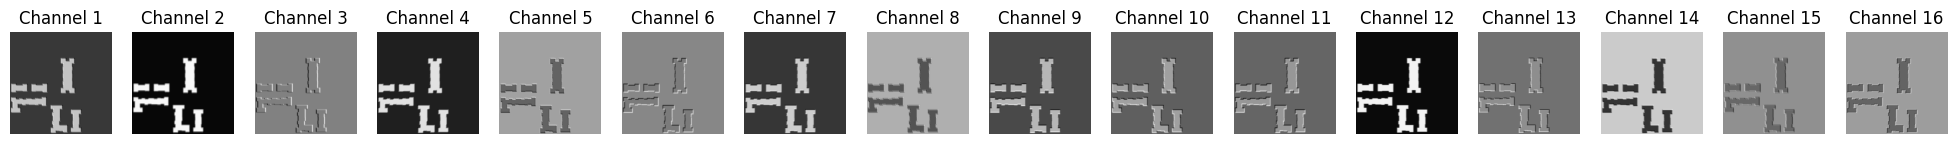

Feature maps for ground-truth correction:


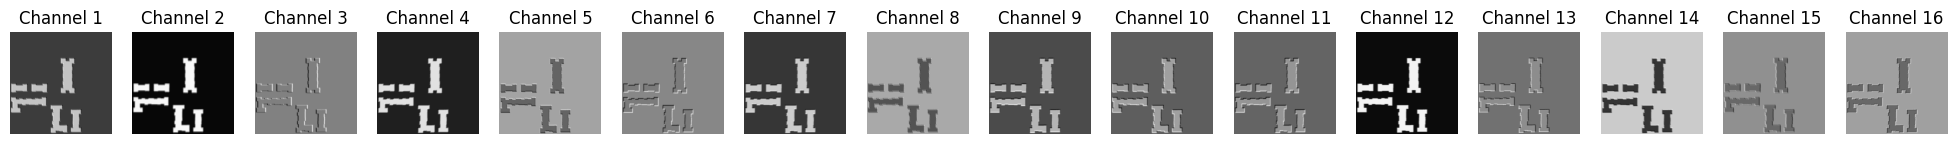

Visualizing feature maps for layer: 5
Feature maps for predicted corrections:


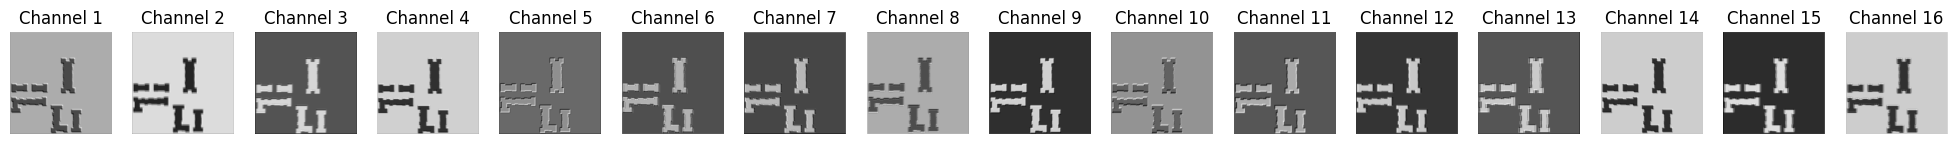

Feature maps for ground-truth correction:


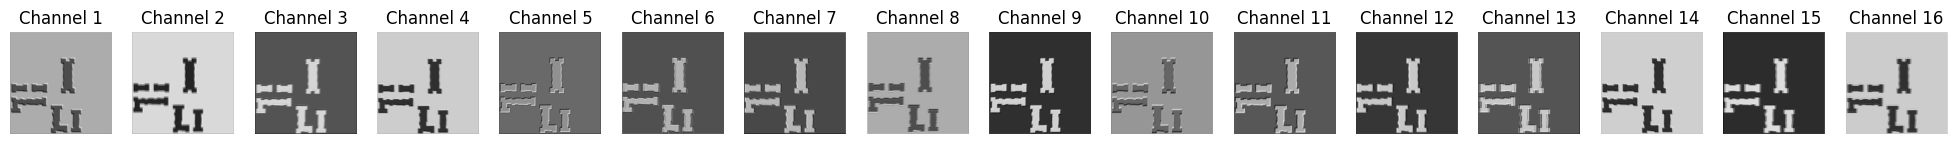

Visualizing feature maps for layer: 10
Feature maps for predicted corrections:


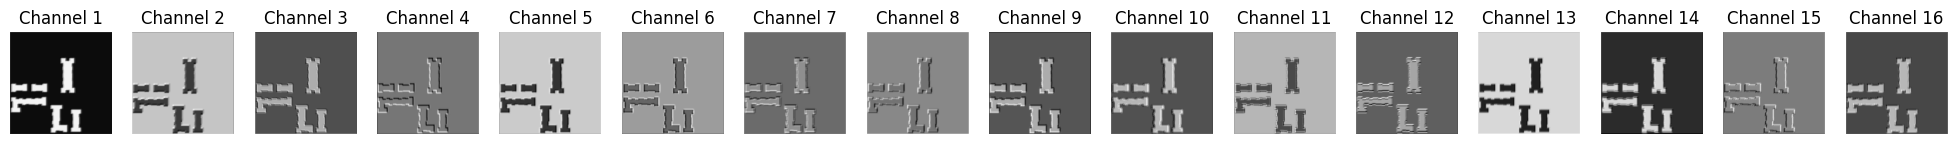

Feature maps for ground-truth correction:


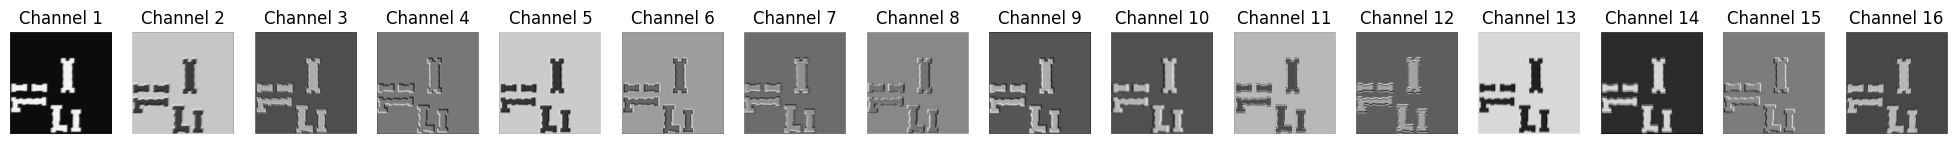

Visualizing feature maps for layer: 19
Feature maps for predicted corrections:


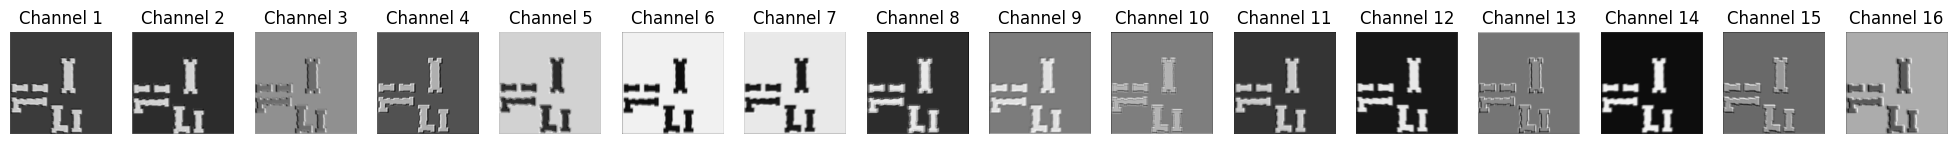

Feature maps for ground-truth correction:


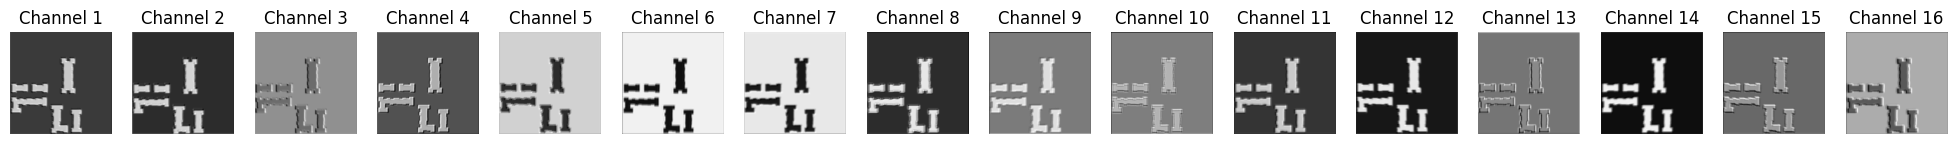

Visualizing feature maps for layer: 28
Feature maps for predicted corrections:


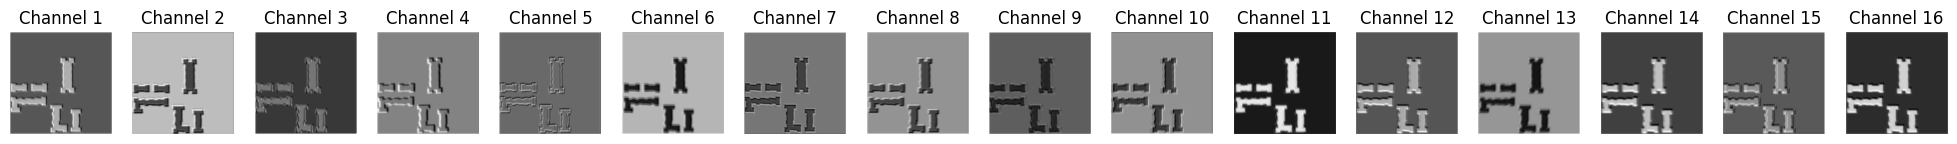

Feature maps for ground-truth correction:


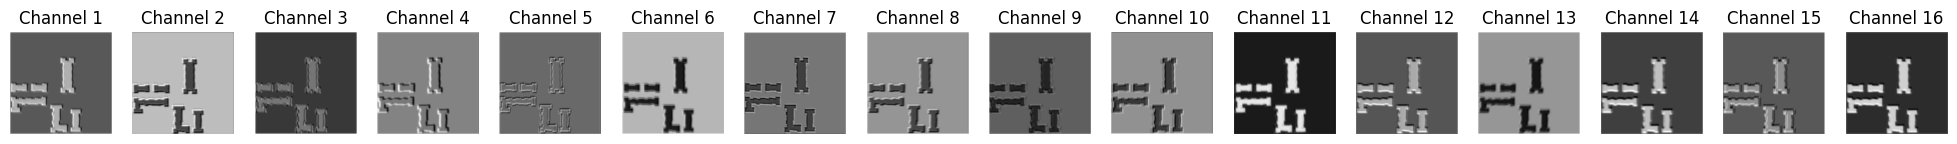

tensor(0.0195)

In [28]:

perceptual_loss = PerceptualLoss(visualize=True)
perceptual_loss(raw, correction)

## Perceptual loss для MobileNetV2 (pretrained on ImageNet)

In [47]:
TARGET_PATH = 'data/processed/gds_dataset/correction/test_correction'
MASK_PATH = 'inference/output_img/exp_6'
BATCH_SIZE = 1

TRANSFORM = transforms.Compose([transforms.Resize((1024,1024)), 
                                transforms.ToTensor(),
                                transforms.Grayscale()])
#EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = apply_transform(binarize_flag=True))
EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = TRANSFORM)
EVAL_LOADER = DataLoader(EVAL_DATASET, batch_size = BATCH_SIZE, shuffle=True)

In [53]:
raw, correction = next(iter(EVAL_LOADER))
print(raw)
print(correction.shape)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
torch.Size([1, 1, 1024, 1024])


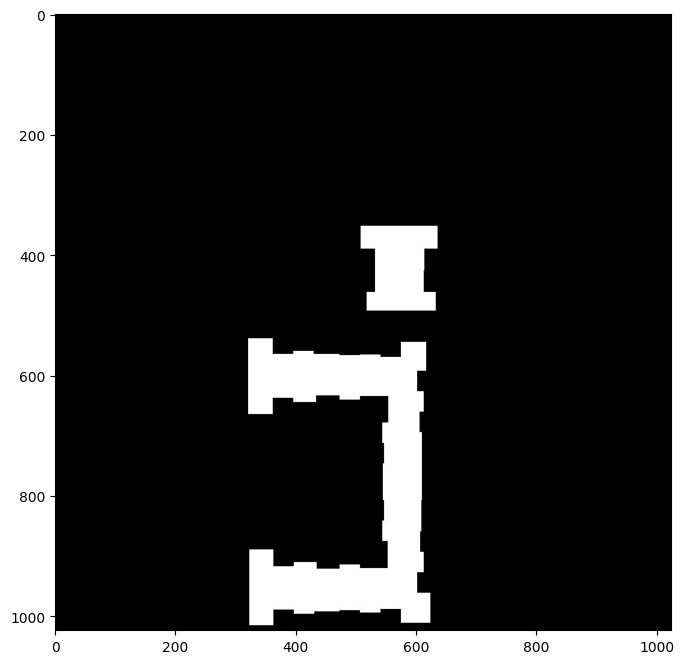

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(raw.squeeze(0,1), cmap='gray')
plt.show()

In [22]:
feature_extractor.features[5].conv[2]

Conv2d(144, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [90]:
raw_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [44]:
feature_extractor = models.mobilenet_v2(pretrained=True)
downsampling = nn.Sequential(
    nn.Conv2d(1,1, kernel_size=3, stride=4, padding=1),
    nn.ReLU()
)
features = list(feature_extractor.features)
features.insert(0, downsampling)
feature_extractor.features = nn.Sequential(*features)
feature_extractor.features[1][0] = nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1)
feature_extractor.classifier[1] = nn.Linear(feature_extractor.last_channel, 1)

In [14]:
class MobileNetPerceptualLoss(nn.Module):
    def __init__(self, feature_extractor, selected_layers, visualize=False):
        super(MobileNetPerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.selected_layers = selected_layers
        self.feature_outputs = {}
        self.visualize = visualize

        # Register forward hooks for the selected layers

        for layer_idx in self.selected_layers:
            self.feature_extractor.features[layer_idx].register_forward_hook(
                self.save_output(layer_idx)
            )

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def save_output(self, layer_idx):
        """
        Hook to save the output of the specified layer
        """
        def hook(module, input, output):
            self.feature_outputs[layer_idx] = output
        return hook
        
    def forward(self, img1, img2):
        # Forward pass through feature extractor
        _ = self.feature_extractor(img1)
        features1 = self.feature_outputs.copy()

        _ = self.feature_extractor(img2)
        features2 = self.feature_outputs.copy()

        # Compute perceptual loss as a L1-disttance between corresponding layers
        loss = 0
        for layer_idx in self.selected_layers:
            loss_iter = torch.nn.functional.l1_loss(features1[layer_idx], features2[layer_idx]) 
            loss += loss_iter
            print(f'Loss value from layer {layer_idx}: {loss_iter}')
        if self.visualize:
            self.visualize_feature_maps(img1, img2)
        return loss

    def visualize_feature_maps(self, img1, img2):
        _ = self.feature_extractor(img1)
        features1 = self.feature_outputs.copy()
        print(features1[1].shape)

        _ = self.feature_extractor(img2)
        features2 = self.feature_outputs.copy()

        for layer_idx in self.selected_layers:
            print(f'Visualizing layer: {layer_idx}')
            num_channels = features1[layer_idx].shape[1]
            num_to_plot = min(16, num_channels) # plot up to 16 feature maps
            
            print(f'Feature maps for predicted corrections:')
            fig, axes = plt.subplots(1, num_to_plot, figsize=(25,5))
            if num_to_plot == 1:
                axes = [axes]
            for i in range(num_to_plot):
                axes[i].imshow(features1[layer_idx].squeeze(0)[i].detach().cpu().numpy(), cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(f'Channel {i+1}')
            plt.show()

            print(f'Feature maps for ground-truth correction:')
            fig, axes = plt.subplots(1, num_to_plot, figsize=(25,5))
            if num_to_plot == 1:
                axes = [axes]
            for i in range(num_to_plot):
                axes[i].imshow(features2[layer_idx].squeeze(0)[i].detach().cpu().numpy(), cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(f'Channel {i+1}')
            plt.show()

Loss value from layer 1: 0.005526193417608738
Loss value from layer 2: 0.03973877429962158
Loss value from layer 3: 0.05170300602912903
Loss value from layer 4: 0.10429301112890244
Loss value from layer 7: 0.12210384011268616
Loss value from layer 13: 0.11197581887245178
Loss value from layer 15: 0.05535402148962021
Loss value from layer 17: 0.12259314209222794
torch.Size([1, 32, 128, 128])
Feature maps for predicted corrections:


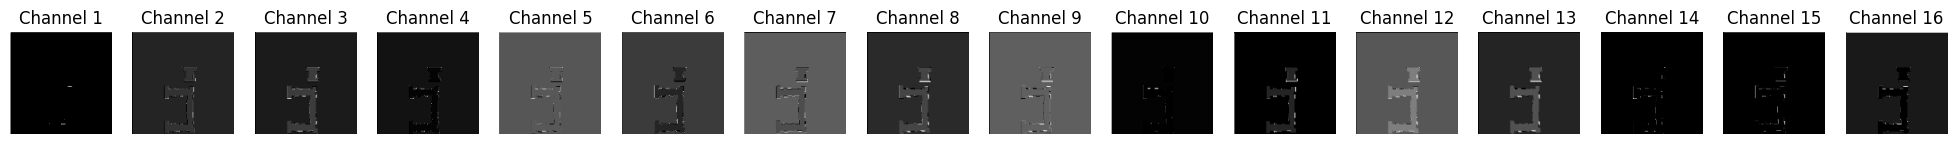

Feature maps for ground-truth correction:


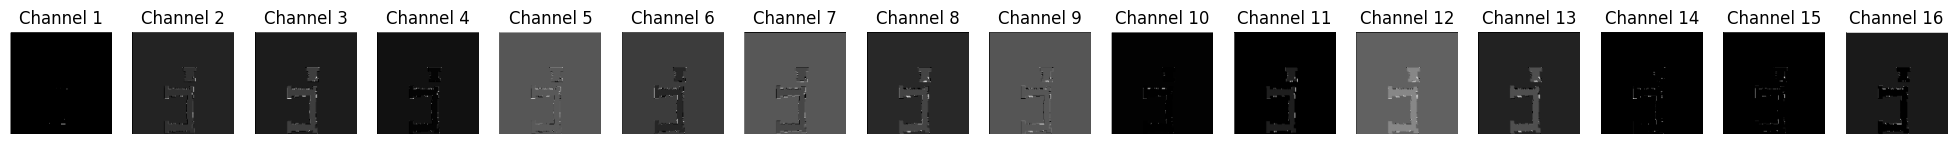

Feature maps for predicted corrections:


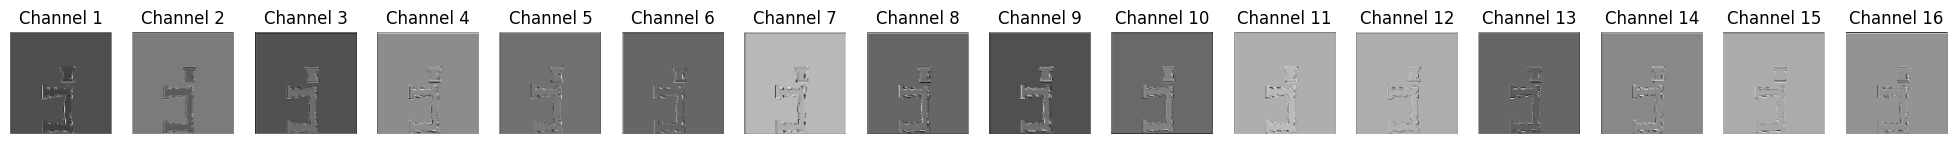

Feature maps for ground-truth correction:


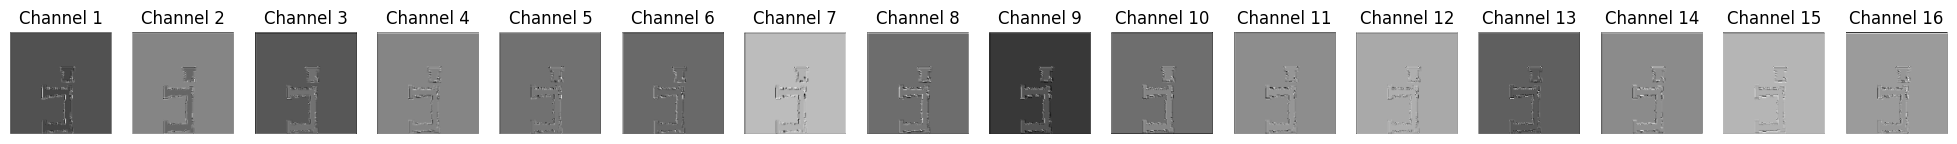

Feature maps for predicted corrections:


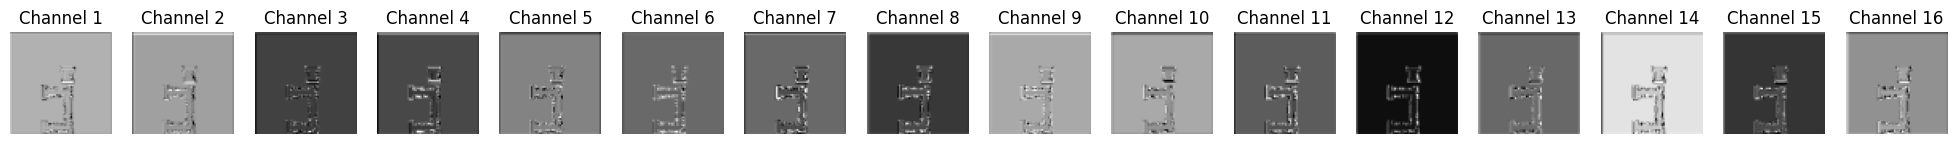

Feature maps for ground-truth correction:


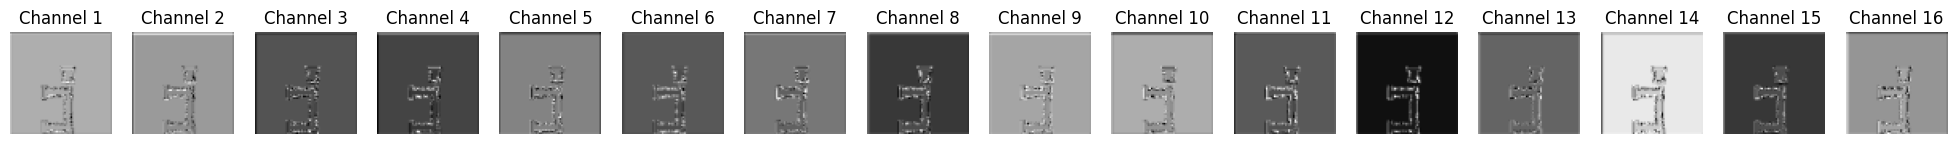

Feature maps for predicted corrections:


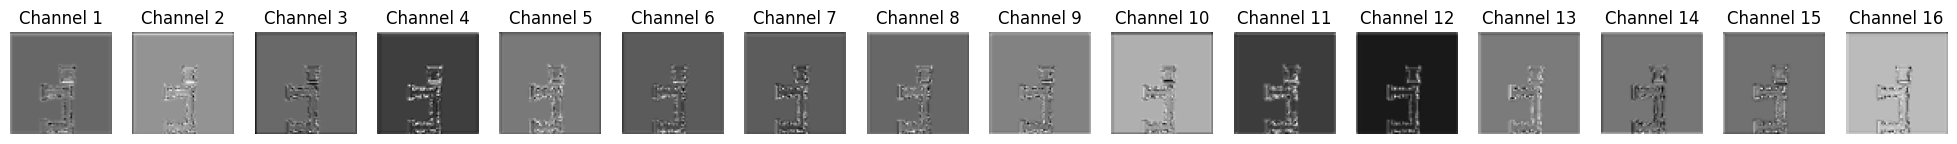

Feature maps for ground-truth correction:


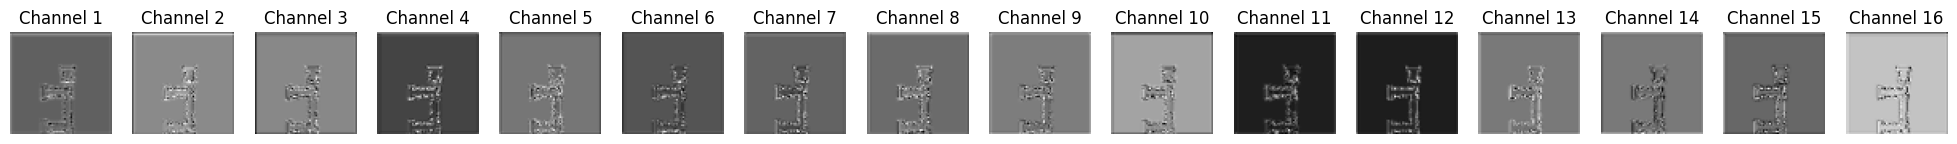

Feature maps for predicted corrections:


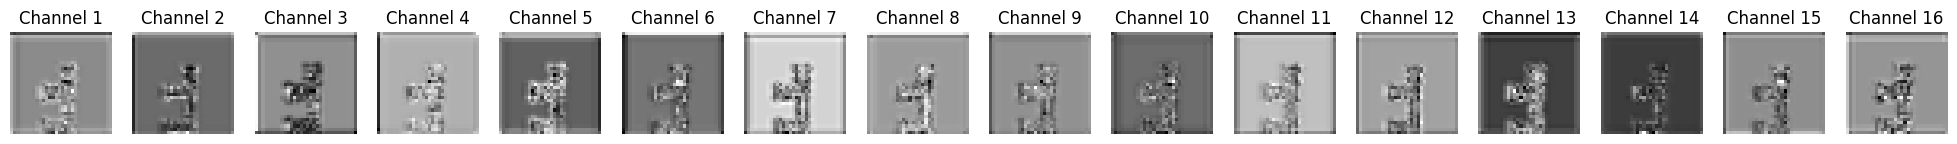

Feature maps for ground-truth correction:


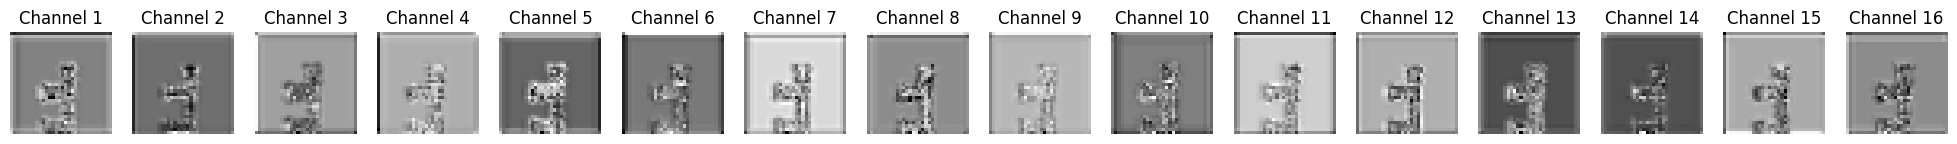

Feature maps for predicted corrections:


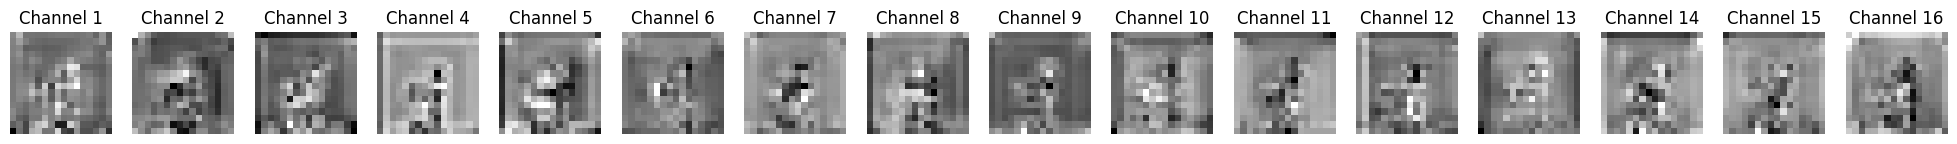

Feature maps for ground-truth correction:


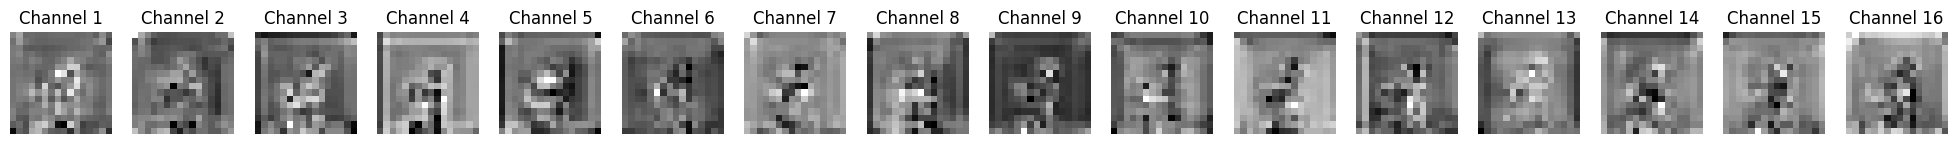

Feature maps for predicted corrections:


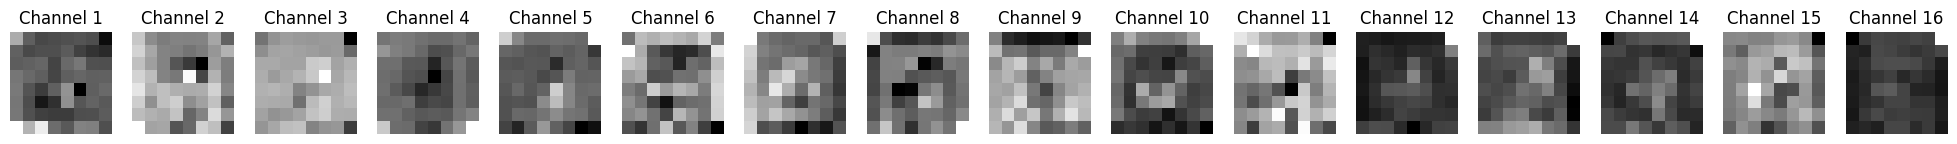

Feature maps for ground-truth correction:


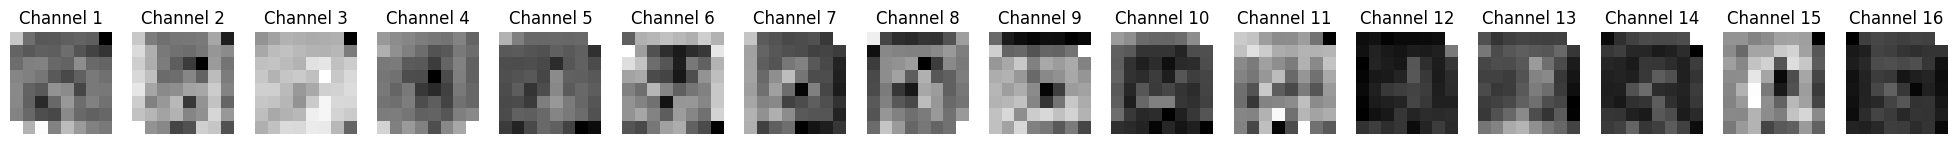

Feature maps for predicted corrections:


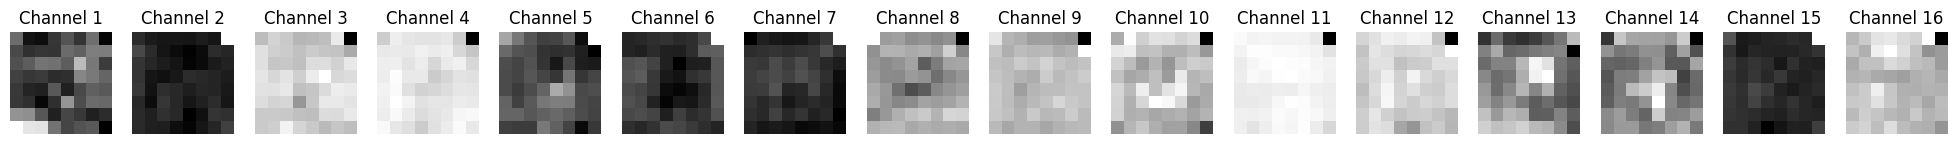

Feature maps for ground-truth correction:


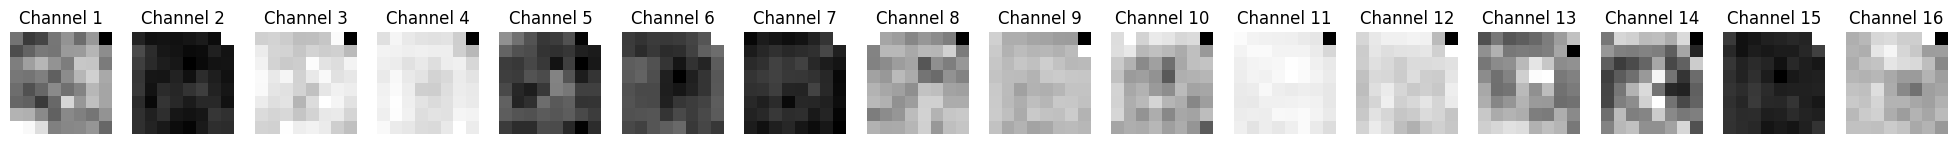

tensor(0.6133)


In [100]:
selected_layers = [1,2, 3,4,7, 13, 15, 17]

#feature_extractor = models.mobilenet_v2(pretrained=True).classifier
perceptual_loss = MobileNetPerceptualLoss(feature_extractor, selected_layers, visualize=True)

loss = perceptual_loss(raw, correction)
print(loss)

## Perceptual loss, обученный на картинках топологии

In [6]:
# для дальнейшего использования
feature_extractor = models.mobilenet_v2(pretrained=True)
downsampling = nn.Sequential(
    nn.Conv2d(1,1, kernel_size=3, stride=4, padding=1),
    nn.ReLU()
)
features = list(feature_extractor.features)
features.insert(0, downsampling)
feature_extractor.features = nn.Sequential(*features)
feature_extractor.features[1][0] = nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1)
feature_extractor.classifier[1] = nn.Linear(feature_extractor.last_channel, 1)


feature_extractor.load_state_dict(torch.load('/home/amoskovtsev/Загрузки/mobilenet_topology_classifier_v1.pth')['model_state_dict'])
feature_extractor.eval()

/scratch/amoskovtsev/miniconda3/envs/mb_opc/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/amoskovtsev/miniconda3/envs/mb_opc/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
      (1): ReLU()
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
    

In [22]:
class MobileNetPerceptualLoss(nn.Module):
    def __init__(self, feature_extractor, selected_layers, visualize=False):
        super(MobileNetPerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.selected_layers = selected_layers
        self.feature_outputs = {}
        self.visualize = visualize

        # Register forward hooks for the selected layers

        for layer_idx in self.selected_layers:
            self.feature_extractor.features[layer_idx].register_forward_hook(
                self.save_output(layer_idx)
            )

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def save_output(self, layer_idx):
        """
        Hook to save the output of the specified layer
        """
        def hook(module, input, output):
            self.feature_outputs[layer_idx] = output
        return hook
        
    def forward(self, img1, img2):
        # Forward pass through feature extractor
        _ = self.feature_extractor(img1)
        features1 = self.feature_outputs.copy()

        _ = self.feature_extractor(img2)
        features2 = self.feature_outputs.copy()

        # Compute perceptual loss as a L1-disttance between corresponding layers
        loss = 0
        for layer_idx in self.selected_layers:
            loss_iter = torch.nn.functional.l1_loss(features1[layer_idx], features2[layer_idx]) 
            loss += loss_iter
            print(f'Loss value from layer {layer_idx}: {loss_iter}')
        if self.visualize:
            self.visualize_feature_maps(img1, img2)
        return loss

    def visualize_feature_maps(self, img1, img2):
        _ = self.feature_extractor(img1)
        features1 = self.feature_outputs.copy()
        print(features1[1].shape)

        _ = self.feature_extractor(img2)
        features2 = self.feature_outputs.copy()

        for layer_idx in self.selected_layers:
            print(f'Visualizing layer: {layer_idx}')
            num_channels = features1[layer_idx].shape[1]
            num_to_plot = min(16, num_channels) # plot up to 16 feature maps
            
            print(f'Feature maps for predicted corrections:')
            fig, axes = plt.subplots(1, num_to_plot, figsize=(25,5))
            if num_to_plot == 1:
                axes = [axes]
            for i in range(num_to_plot):
                axes[i].imshow(features1[layer_idx].squeeze(0)[i].detach().cpu().numpy(), cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(f'Channel {i+1}')
            plt.show()

            print(f'Feature maps for ground-truth correction:')
            fig, axes = plt.subplots(1, num_to_plot, figsize=(25,5))
            if num_to_plot == 1:
                axes = [axes]
            for i in range(num_to_plot):
                axes[i].imshow(features2[layer_idx].squeeze(0)[i].detach().cpu().numpy(), cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(f'Channel {i+1}')
            plt.show()

In [18]:
TARGET_PATH = 'data/processed/gds_dataset/correction/test_correction'
MASK_PATH = 'inference/output_img/exp_6'
BATCH_SIZE = 1

TRANSFORM = transforms.Compose([transforms.Resize((1024,1024)), 
                                transforms.ToTensor(),
                                transforms.Grayscale()])
#EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = apply_transform(binarize_flag=True))
EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = TRANSFORM)
EVAL_LOADER = DataLoader(EVAL_DATASET, batch_size = BATCH_SIZE, shuffle=True)

In [23]:
raw, correction = next(iter(EVAL_LOADER))
print(raw)
print(correction.shape)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
torch.Size([1, 1, 1024, 1024])


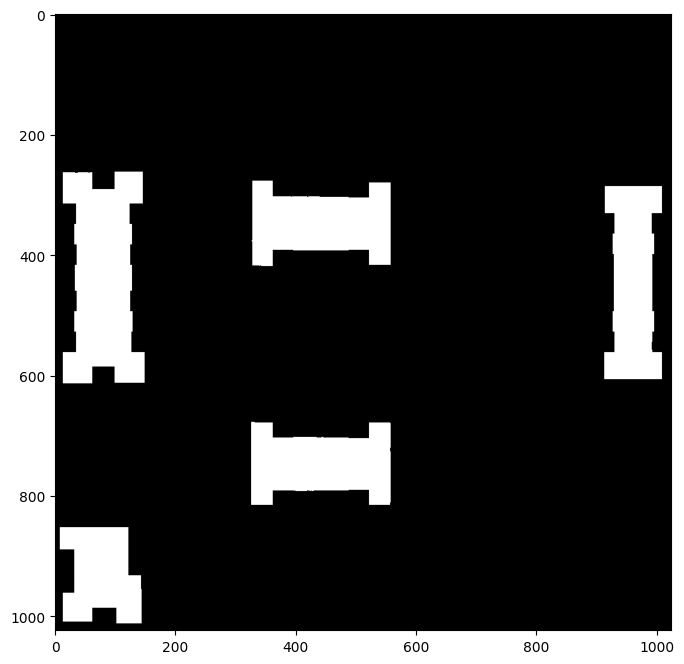

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(correction.squeeze(0,1), cmap='gray')
plt.show()

Loss value from layer 1: 0.0012654473539441824
Loss value from layer 2: 0.01373840682208538
Loss value from layer 3: 0.01833358407020569
Loss value from layer 4: 0.040554147213697433
Loss value from layer 7: 0.05625919625163078
Loss value from layer 8: 0.04276437312364578
Loss value from layer 9: 0.06337536126375198
Loss value from layer 10: 0.07713155448436737
Loss value from layer 11: 0.08806073665618896
Loss value from layer 12: 0.04946693405508995
Loss value from layer 13: 0.07148148119449615
Loss value from layer 14: 0.0876694843173027
Loss value from layer 15: 0.04014942795038223
Loss value from layer 16: 0.06255392730236053
Loss value from layer 17: 0.0970722958445549
torch.Size([1, 32, 128, 128])
Visualizing layer: 1
Feature maps for predicted corrections:


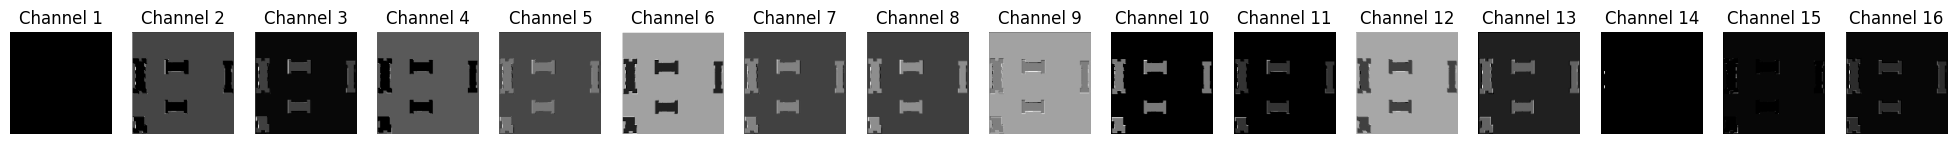

Feature maps for ground-truth correction:


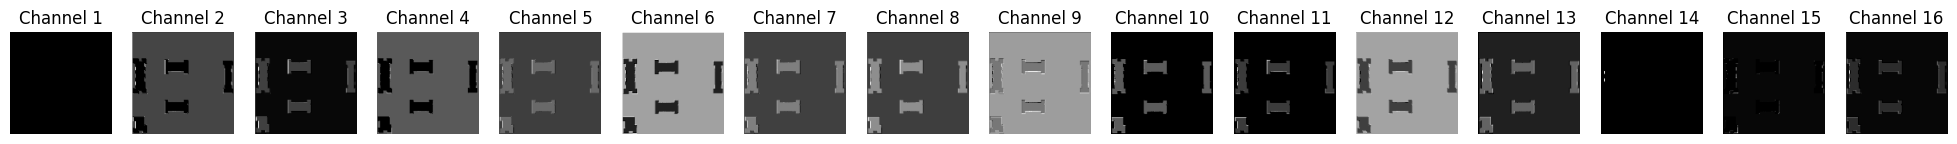

Visualizing layer: 2
Feature maps for predicted corrections:


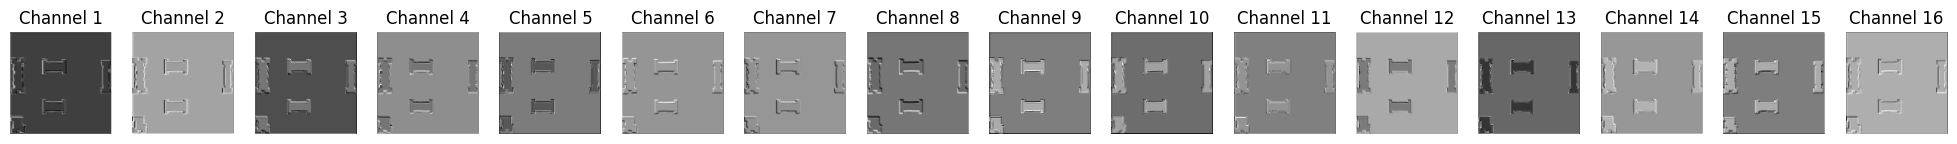

Feature maps for ground-truth correction:


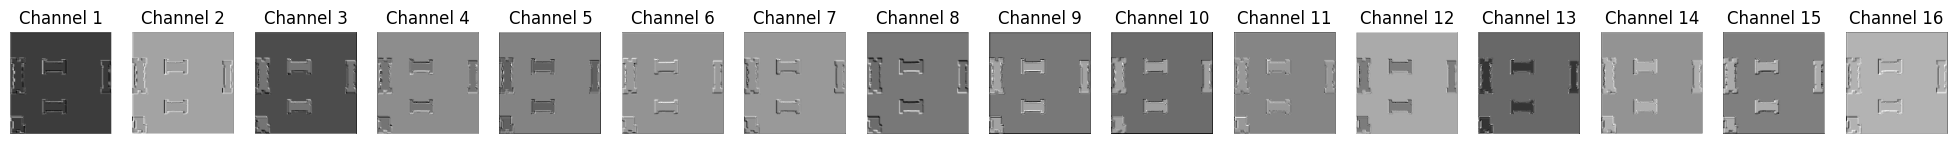

Visualizing layer: 3
Feature maps for predicted corrections:


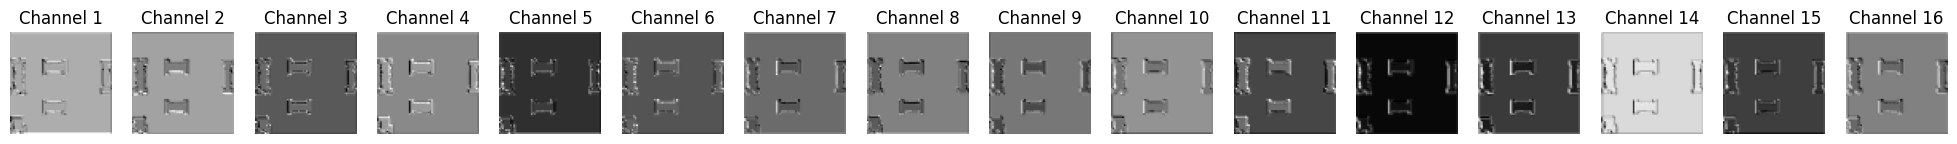

Feature maps for ground-truth correction:


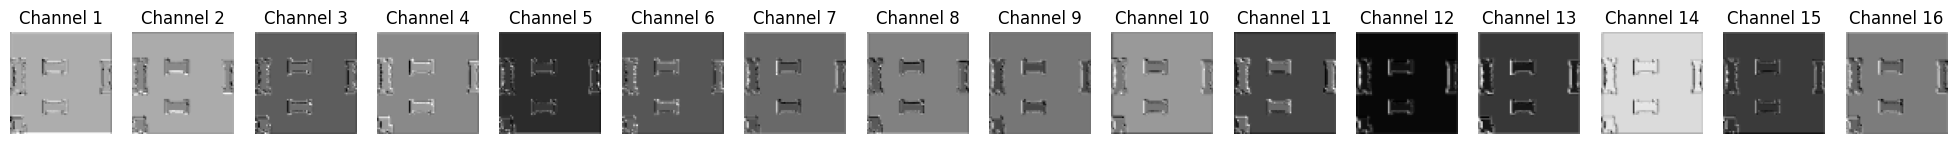

Visualizing layer: 4
Feature maps for predicted corrections:


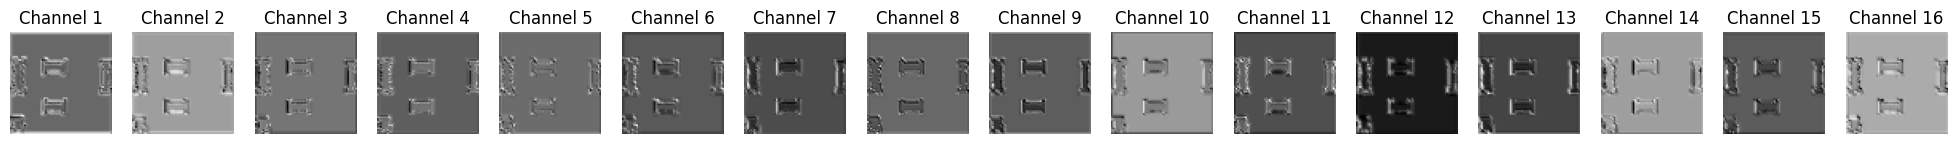

Feature maps for ground-truth correction:


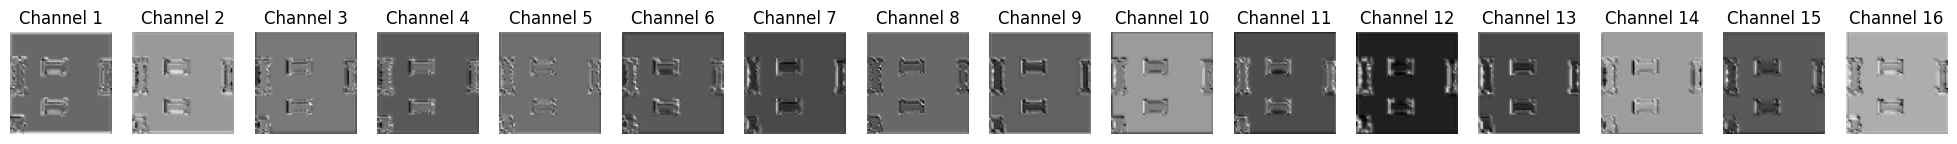

Visualizing layer: 7
Feature maps for predicted corrections:


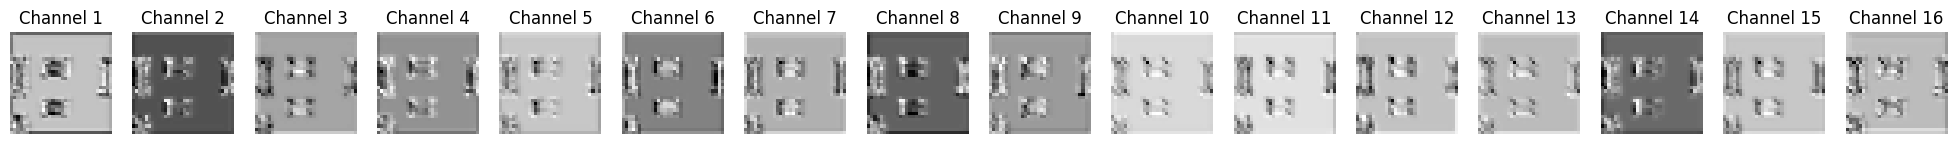

Feature maps for ground-truth correction:


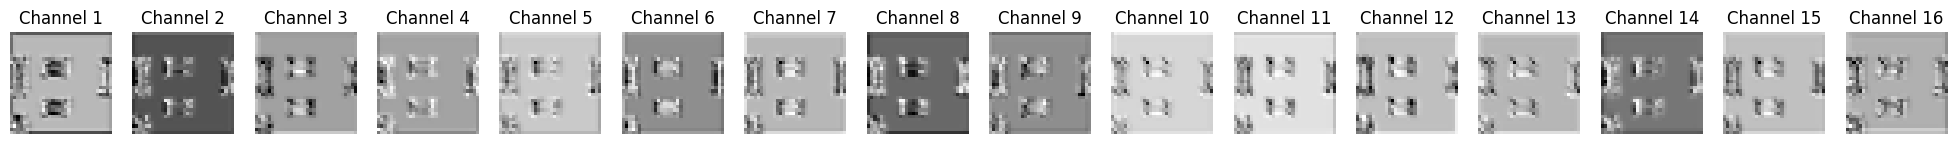

Visualizing layer: 8
Feature maps for predicted corrections:


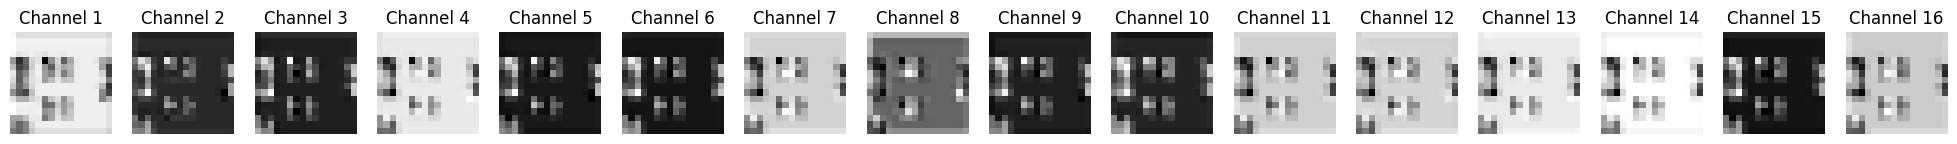

Feature maps for ground-truth correction:


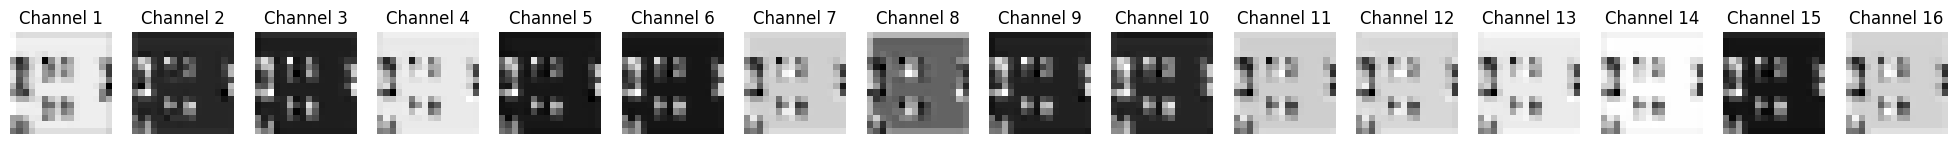

Visualizing layer: 9
Feature maps for predicted corrections:


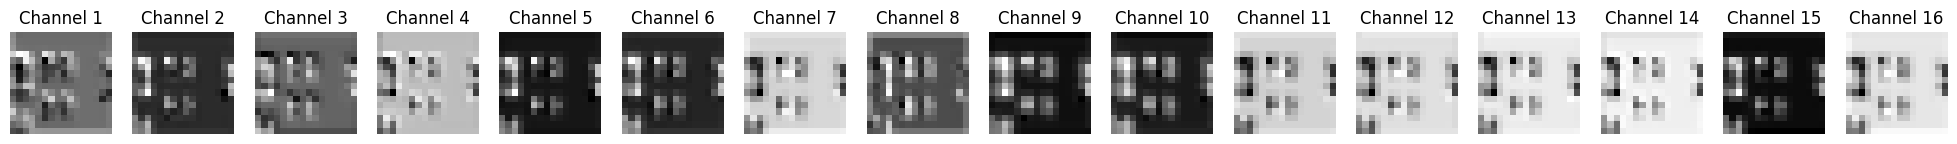

Feature maps for ground-truth correction:


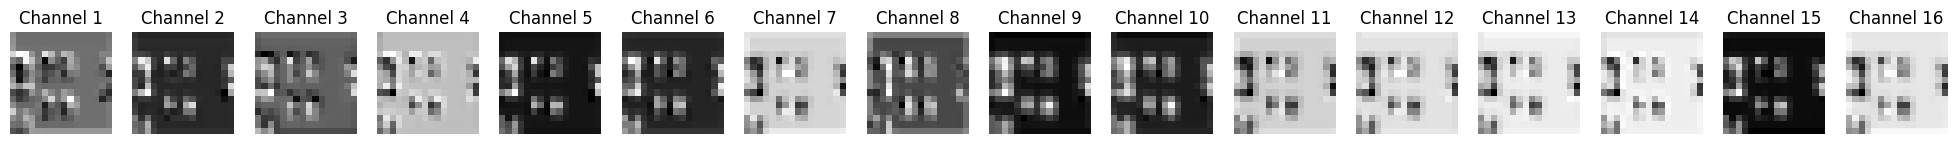

Visualizing layer: 10
Feature maps for predicted corrections:


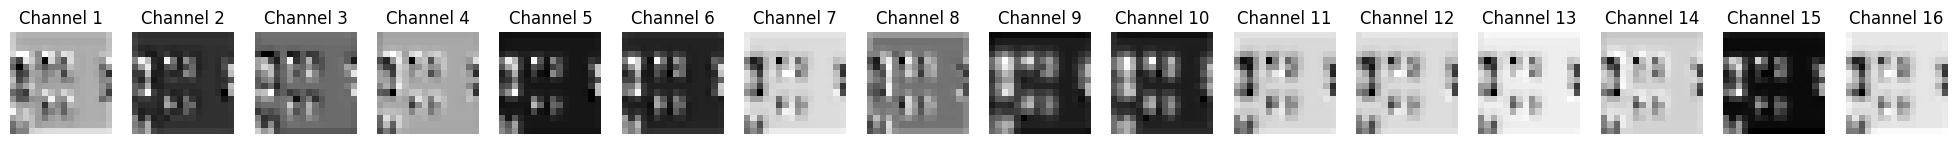

Feature maps for ground-truth correction:


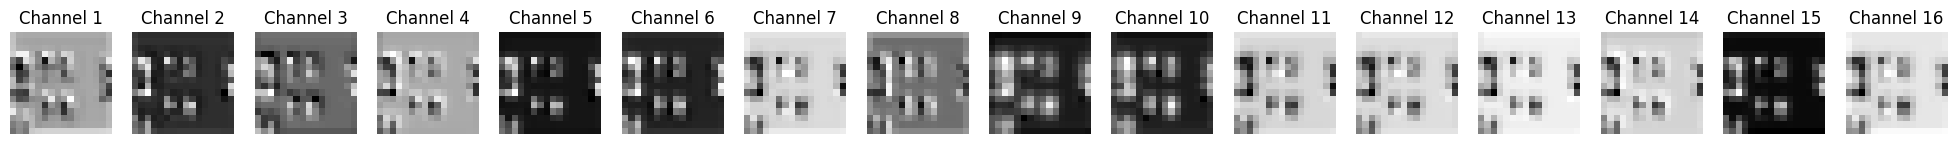

Visualizing layer: 11
Feature maps for predicted corrections:


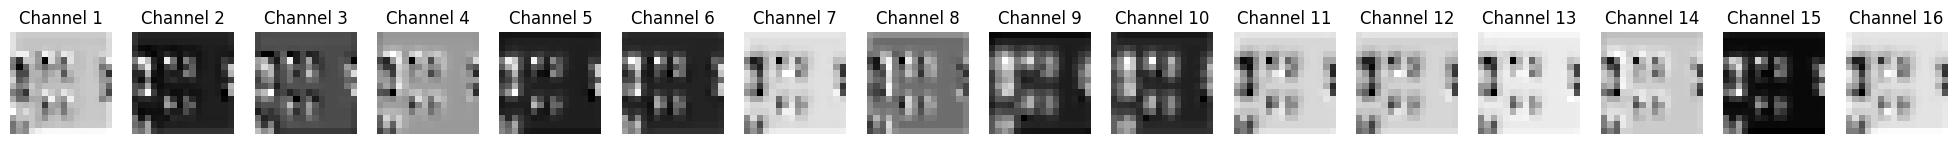

Feature maps for ground-truth correction:


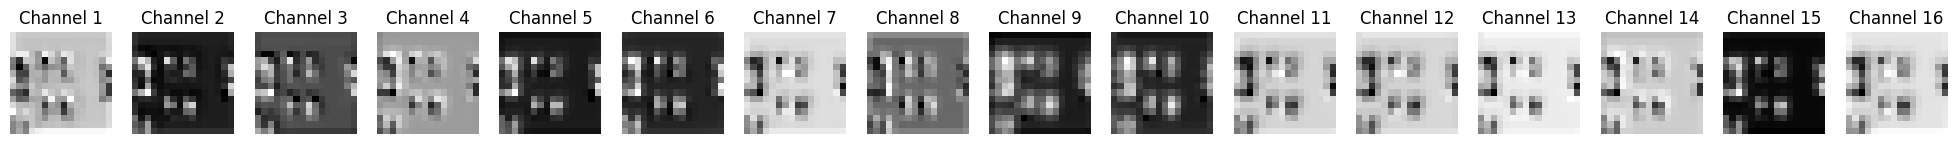

Visualizing layer: 12
Feature maps for predicted corrections:


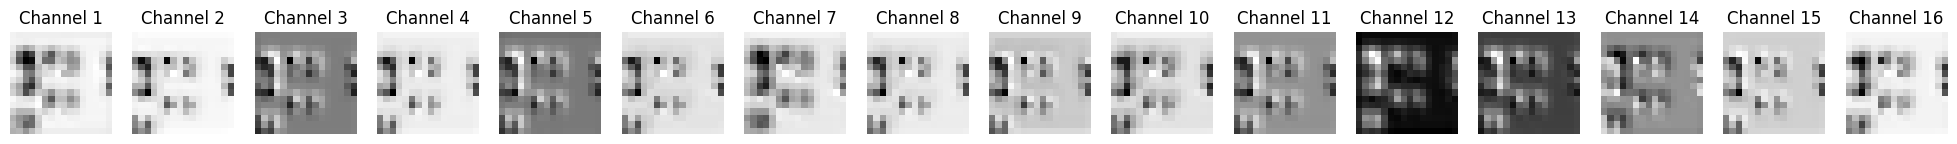

Feature maps for ground-truth correction:


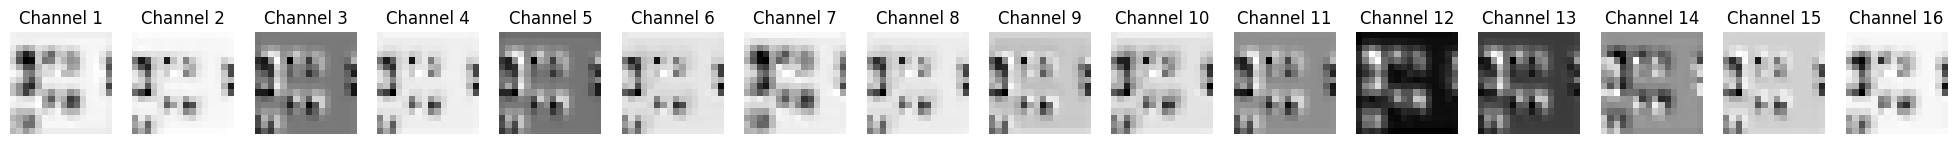

Visualizing layer: 13
Feature maps for predicted corrections:


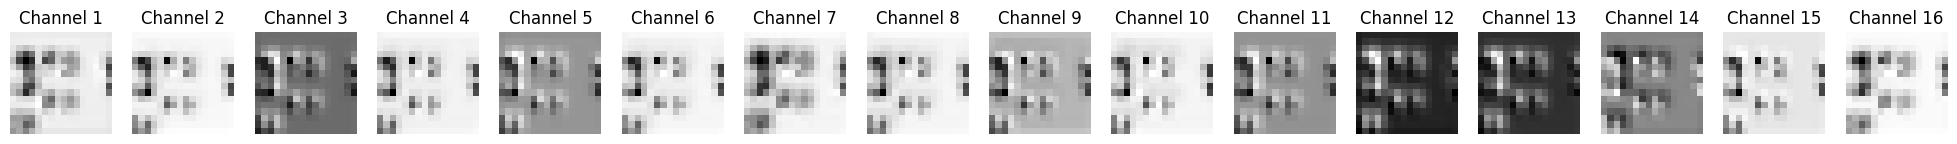

Feature maps for ground-truth correction:


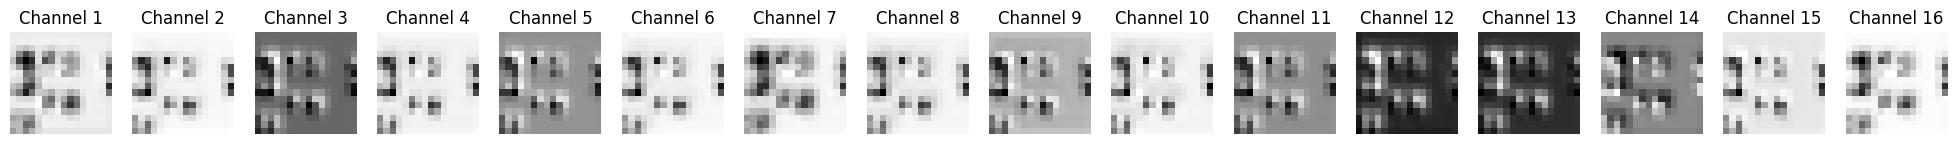

Visualizing layer: 14
Feature maps for predicted corrections:


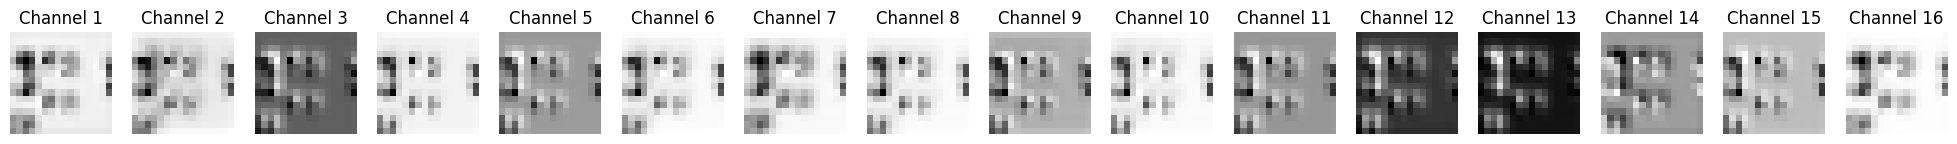

Feature maps for ground-truth correction:


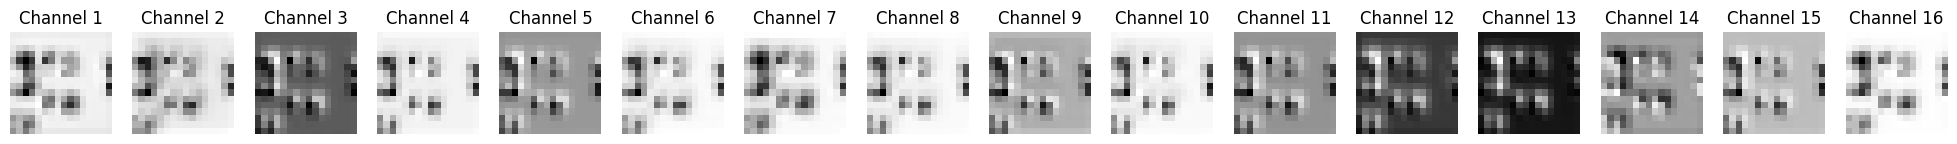

Visualizing layer: 15
Feature maps for predicted corrections:


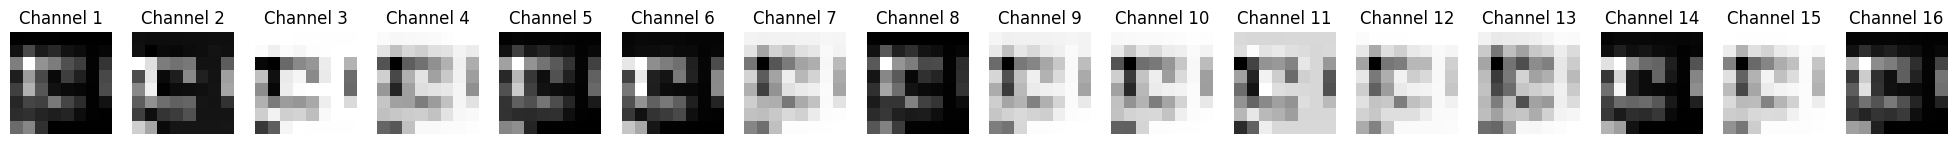

Feature maps for ground-truth correction:


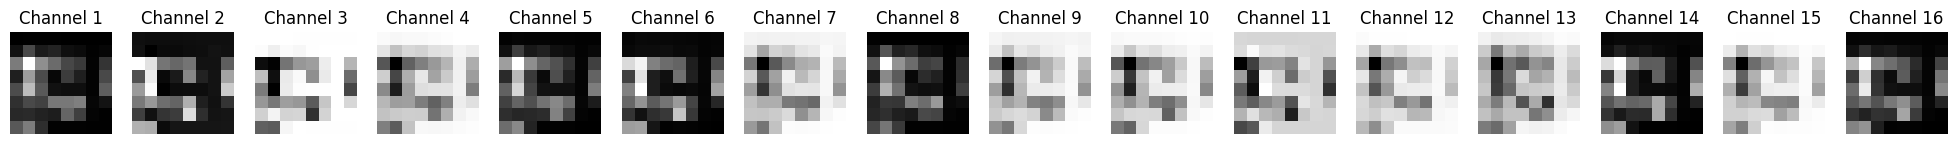

Visualizing layer: 16
Feature maps for predicted corrections:


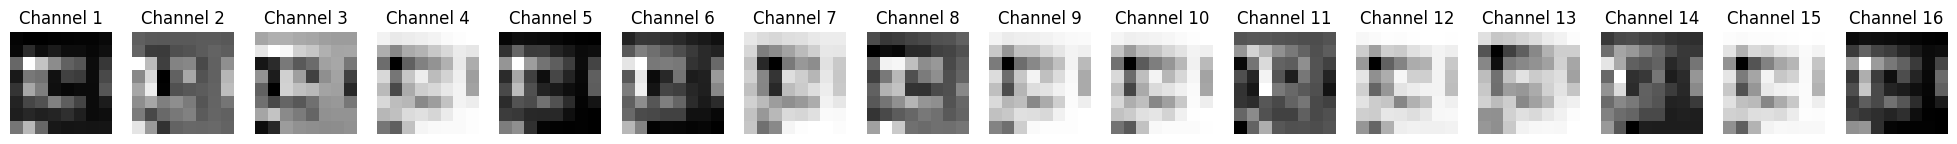

Feature maps for ground-truth correction:


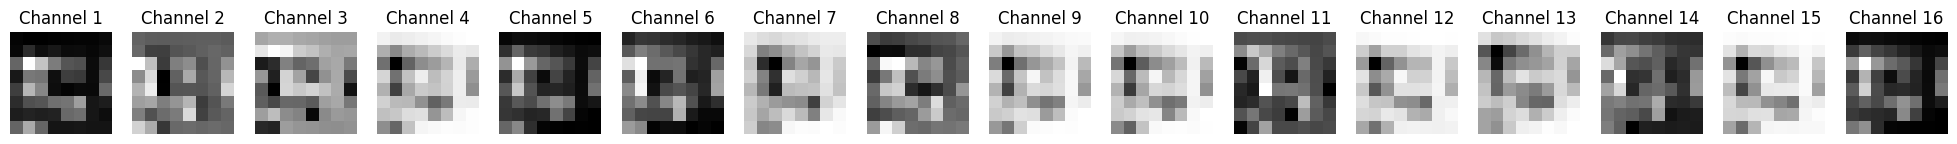

Visualizing layer: 17
Feature maps for predicted corrections:


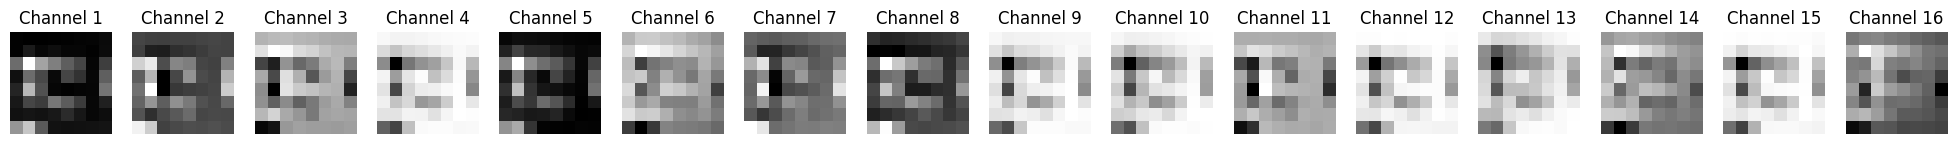

Feature maps for ground-truth correction:


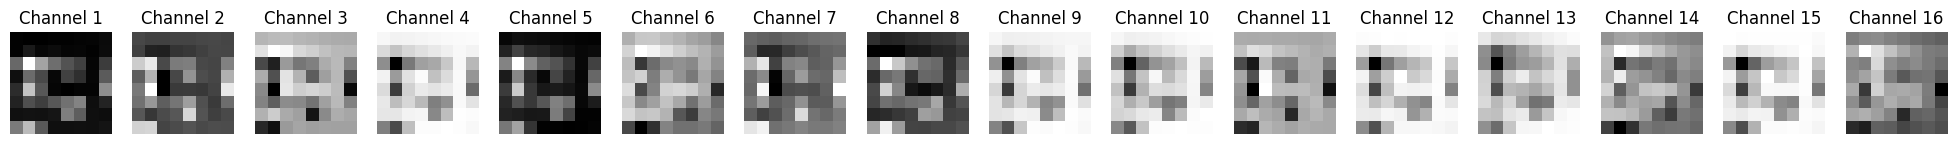

tensor(0.8099)


In [25]:
selected_layers = [1,2,3,4,7,8,9,10,11,12,13,14 ,15, 16 ,17]

#feature_extractor = models.mobilenet_v2(pretrained=True).classifier
perceptual_loss = MobileNetPerceptualLoss(feature_extractor, selected_layers, visualize=True)

loss = perceptual_loss(raw, correction)
print(loss)

## Perceptual Loss для своей сетки

In [8]:
TARGET_PATH = 'data/processed/gds_dataset/correction/test_correction'
MASK_PATH = 'data/processed/gds_dataset/origin/test_origin'
BATCH_SIZE = 1

TRANSFORM = transforms.Compose([
    transforms.Resize(1024),
    transforms.ToTensor(),
    transforms.Grayscale(),
    BinarizeTransform(threshold=0.5)
  ])

#EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = apply_transform(binarize_flag=True))
EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = TRANSFORM)
EVAL_LOADER = DataLoader(EVAL_DATASET, batch_size = BATCH_SIZE)

In [22]:
raw, correction = next(iter(EVAL_LOADER))
print(correction)
print(raw.shape)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
torch.Size([1, 3, 1024, 1024])


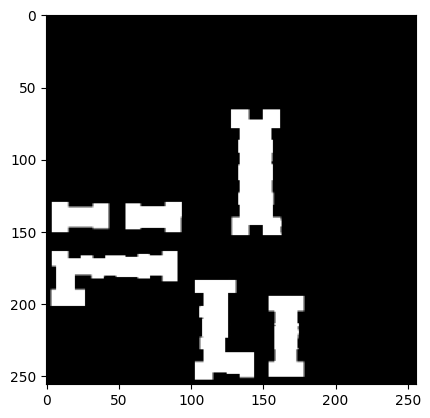

In [23]:
plt.imshow()
# plt.imshow(transforms.Resize(256)(correction).squeeze(0,1), cmap='gray')
# plt.show()

In [10]:
class BinaryClassificationCNN(nn.Module):
  def __init__(self):
    super(BinaryClassificationCNN, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: 16 x 512 x 512
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # Output: 32 x 256 x 256
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Output: 64 x 128 x 128
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 128 x 64 x 64
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) # Output: 256 x 32 x 32

    # Fully connected layers
    self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Flattened input to 512 nodes
    self.fc2 = nn.Linear(512, 1)  # Output layer for binary classification

    # Normalization layers
    self.bn1 = nn.BatchNorm2d(16)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(128)
    # Activation and pooling
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.sigmoid = nn.Sigmoid()
    self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.global_avgpool = nn.AdaptiveAvgPool2d((4,4))

  def forward(self, x):
    x = self.avgpool(x)
    x = self.bn1(self.relu(self.conv1(x)))
    x = self.bn2(self.relu(self.conv2(x)))
    x = self.bn3(self.relu(self.conv3(x)))
    x = self.bn4(self.relu(self.conv4(x)))
    x = self.relu(self.conv5(x))

    # Global average pooling
    x = self.global_avgpool(x)

    # Flatten the tensor
    x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers

    # Fully connected layers
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    # Apply sigmoid for binary classification
    #x = self.sigmoid(x)
    return x

class SaveActivations:
  def __init__(self, module):
    self.hook = module.register_forward_hook(self.hook_fn)
    self.features = None
  def hook_fn(self, module, input, output):
    self.features = output
  def remove(self):
    self.hook.remove()

In [ ]:
class NewPerceptualLoss(nn.Module):
  def __init__(self, model, weight=1.0, layers=None):
    super(PerceptualLoss, self).__init__()
      self.model = model
      self.weight = weight
      self.conv2_hook = SaveActivations(classifier_model.conv2)
      self.conv3_hook = SaveActivations(classifier_model.conv3)
      self.conv4_hook = SaveActivations(classifier_model.conv4)
      self.conv5_hook = SaveActivations(classifier_model.conv5)

      
    
      
    # Load pretrained VGG model and select specific layers
    vgg = models.vgg19(weights='VGG19_Weights.DEFAULT').features
    self.layers = layers if layers else [0,5,10,19, 28] # use diferent layers for multiscale features
    self.features = nn.ModuleList([vgg[i] for i in self.layers]).eval()

    # Freeze vgg parameters
    for param in self.features.parameters():
      param.requires_grad = False

  def forward(self, pred, target):

      
    pred, target = self.normalize_input(pred), self.normalize_input(target)
    perceptual_loss = 0.0
    for layer in self.features:
      pred, target = layer(pred), layer(target)
      perceptual_loss += F.l1_loss(pred, target)

    return self.weight * perceptual_loss

  @staticmethod
  def normalize_input(x):
    # Normalize according to VGG preprocessing
    mean = torch.tensor([0.485, 0.456, 0.406]).to(x.device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(x.device)
    x = (x - mean[None, :, None, None]) / std[None, :, None, None]


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = 'checkpoints/exp_22/last_checkpoint.pth'
classifier_model = BinaryClassificationCNN()
classifier_model.load_state_dict(torch.load(MODEL_PATH, map_location = device)['model_state_dict'])
classifier_model = classifier_model.to(device)
classifier_model.eval()
print(classifier_model)

BinaryClassificationCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
  (avgpool): AvgPool2d(ke

IndexError: index 16 is out of bounds for axis 0 with size 16

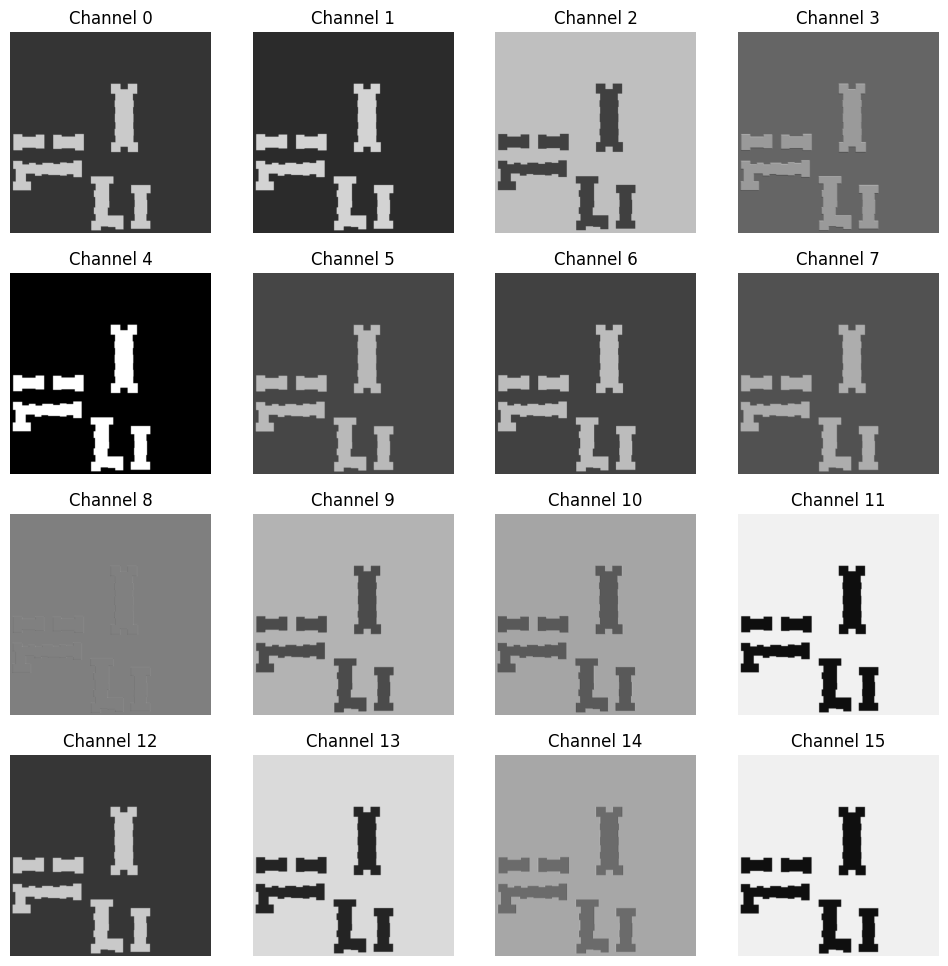

In [16]:
import math
import matplotlib.pyplot as plt
# Number of channels in the feature map
num_channels = fm.shape[1]

# Choose how many channels you want to display (or set to num_channels to show all)
# For large models, it might be impractical to show all feature maps at once.
num_to_display = min(num_channels, 16 + 1)  # For example, display the first 16 channels

# Calculate the grid size (e.g., 4x4 for 16 channels)
grid_size = math.ceil(math.sqrt(num_to_display))

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over the selected channels and display them
for i in range(num_to_display + 1):
    if i == num_to_display:
      axes[i].imshow(raw[0,0].cpu().detach().numpy(), cmap='gray')
      axes[i].set_title(f'Raw image')
      axes[i].axis('off')
      continue

    feature_map = fm[0, i].cpu().detach().numpy()  # Get the i-th feature map
    axes[i].imshow(feature_map, cmap='gray')  # Show the feature map in grayscale
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')  # Hide axis for better visualization

# Turn off any remaining empty subplots
for i in range(num_to_display, len(axes)):
    axes[i].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

# Подсчитаем значение функции потерь для всей выборки из предсказаний и оригинальных коррекций

**Подсчтёт для Perceptual Loss:**

In [7]:
print(f'Length of dataset: {len(EVAL_DATASET)}')
print(f'Length of loader: {len(EVAL_LOADER)}')
total_loss = 0
selected_layers = [1,2,3,4,7,8,9,10,11,12,13,14 ,15, 16 ,17]
perceptual_loss = MobileNetPerceptualLoss(feature_extractor, selected_layers)

for _, (raw, correction) in enumerate(EVAL_LOADER):
    loss_iter = perceptual_loss(raw, correction)
    total_loss += loss_iter

print(f'Mean loss value: {total_loss / len(EVAL_LOADER)}')

Length of dataset: 145
Length of loader: 145
Mean loss value: 0.8210300803184509


**Подсчёт для IoU:**

In [8]:
iou_loss = IouLoss()
total_iou_loss = 0

for _, (raw, correction) in enumerate(EVAL_LOADER):
    iou_loss_iter = iou_loss(raw, correction)
    total_iou_loss += iou_loss_iter
print(f'Mean loss value: {total_iou_loss / len(EVAL_LOADER)}')


Mean loss value: 0.07214124500751495


**Подсчёт для MAE:**

In [9]:
l1_loss = torch.nn.L1Loss()

total_l1_loss = 0
for _, (raw, correction) in enumerate(EVAL_LOADER):
    l1_loss_iter = l1_loss(raw, correction)
    total_l1_loss += l1_loss_iter
print(f'Mean loss value: {total_l1_loss / len(EVAL_LOADER)}')


Mean loss value: 0.0010991489980369806
